# DCGANs

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, Reshape, Conv2DTranspose, BatchNormalization, Dense, LeakyReLU, ReLU, Input, MaxPool2D
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import functools as ft

# Generator
The dimension of Z is $100$ and the width of the images is $28$. The weights are initialized with normal distribution with mean $0$ and standard deviation $0.02$.
For upscaling layers the *Conv2DTranspose* layer is usesd with kernel size of $5x5$. 
Batch normalization is applied at each block. All the activations are *ReLU*, except for the last layer which has a *tanh* activation.

Generator architecture for 64x64x3 images

![dcgan for 64x64x3images](https://miro.medium.com/max/700/1*5ALjnfAqwcWbOsledTBXsw.png)

In [2]:
NOISE_DIM = 100
WIDTH = 28
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def block(m, fs, stride):  
  m.add(Conv2DTranspose(
    filters=fs,
    kernel_size=(5, 5), 
    strides=stride, 
    padding='same', 
    use_bias=False,
    kernel_initializer=initializer
  ))
  m.add(BatchNormalization(momentum=0.5))
  m.add(ReLU())

G = tf.keras.Sequential();
G.add(Input(shape=[NOISE_DIM]))
G.add(Dense(7*7*512, use_bias=False, kernel_initializer=initializer))
G.add(BatchNormalization(momentum=0.5))
G.add(ReLU())
G.add(Reshape((7, 7, 512)))
block(G, 256, (1, 1))
block(G, 128, (2, 2))
G.add(Conv2DTranspose(1, (5, 5), (2, 2), padding='same', activation='tanh', kernel_initializer=initializer, use_bias=False))

# Running the generator

(1, 28, 28, 1)


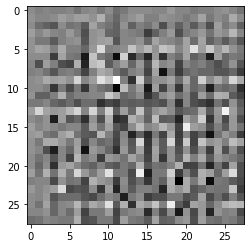

In [3]:
eg = G(tf.random.normal([1, 100]), training = False)
denorm = ((eg[0] * 127.5) + 127.5).numpy().astype(np.uint8).squeeze(2)
plt.imshow(denorm, cmap="gray")
print(eg.shape)

# Discriminator
The discriminator takes an input of shape WIDTHxWIDTH and is followed by convolutional blocks. All convolutions have kernel of $5x5$, batch norm and *LeakyReLU* with a leak of $0.2$ as activation. The weights are initialized similarly to the Generator.
The convolutions are followed by a last dense layer with one single neuron having a *sigmoid* activation which tells whether an image is real (1) or fake (0).

In [4]:
def dblock(m, chs, stride):
  m.add(Conv2D(chs, (5, 5), (stride, stride), 'same', use_bias=False, kernel_initializer=initializer))
  m.add(BatchNormalization(momentum=0.5))
  m.add(LeakyReLU(0.2))

D = tf.keras.Sequential()
D.add(Input(shape=[WIDTH, WIDTH, 1]))
dblock(D, 32, 2)
dblock(D, 64, 2)
dblock(D, 128, 2)
D.add(Flatten())
D.add(Dense(1, activation="sigmoid", kernel_initializer=initializer))

print(D(eg))

tf.Tensor([[0.5000016]], shape=(1, 1), dtype=float32)


# Training loop: a minimax game
The discriminator wants to maximize $log(D(x)) + log(1 - D(G(z)))$.

The generator wants to minimize $log(1 - D(G(z)))$. However, as mentioned in the original GAN paper, the GAN can easily get stuck at the beginning, since the discriminator's job is fairly easy compared to the generator's one. Therefore, the authors of the GAN paper also suggest for the generator to maximize $log(D(G(z)))$ to avoid this problem.

The loss is the BCE for both the discriminator and the generator.

In [7]:
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = BCE(tf.ones_like(real_output), real_output)
  fake_loss = BCE(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss
  
def generator_loss(fake_output):
  return BCE(tf.ones_like(fake_output), fake_output)

g_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
d_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

SEED = tf.random.normal([7*7, NOISE_DIM])

@tf.function
def train_step(xs_real):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    zs = tf.random.normal([xs_real.shape[0], NOISE_DIM])
    xs_fake = G(zs, training=True)

    real_output = D(xs_real, training=True)
    fake_output = D(xs_fake, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))

  return [gen_loss, disc_loss]

def train(dataset, epochs):
  losses = np.empty([0, 2])  
  for epoch in range(epochs):
    print("Epoch {}/{}:".format(epoch+1, epochs))
    progbar = tf.keras.utils.Progbar(len(dataset))
    for image_batch in dataset:
      los = train_step(image_batch)
      losses = np.append(losses, [los], axis=0)
      progbar.add(1)

    if (epoch+1) % 2 == 0:
      show_generations(SEED)
      
  return losses

def show_generations(seed):
  imgs = G(seed, training=False)
  plt.figure(figsize=(14, 14))
  for i in range(imgs.shape[0]):
    img = imgs[i]
    plt.subplot(7, 7, i+1)
    plt.axis("off")
    plt.imshow((img * 127.5 + 127.5).numpy().squeeze(2).astype(np.uint8), cmap="gray")
  plt.show()

# Training
The dataset fashion_mnist is used and the examples are normalized to the tanh codomain $(-1, 1)$.

The batch size is $128$ as suggested in the original paper

Real examples:


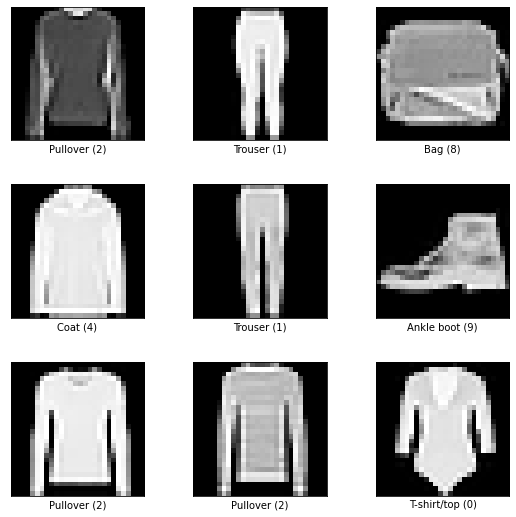

Epoch 1/20:
469/469 [==============================] - 21s 38ms/step
Epoch 2/20:
469/469 [==============================] - 17s 36ms/step


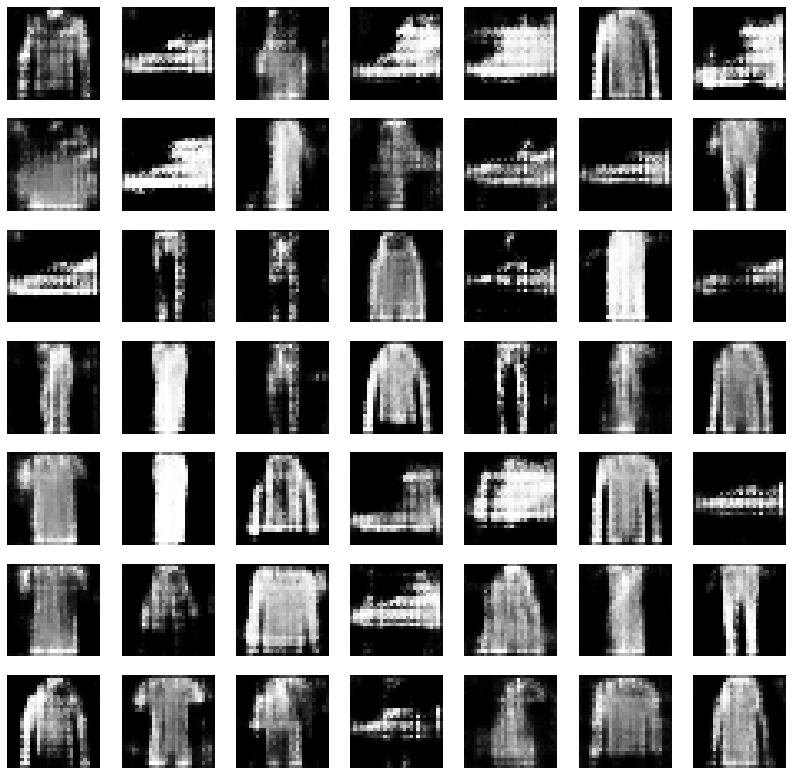

Epoch 3/20:
469/469 [==============================] - 17s 36ms/step
Epoch 4/20:
469/469 [==============================] - 17s 36ms/step


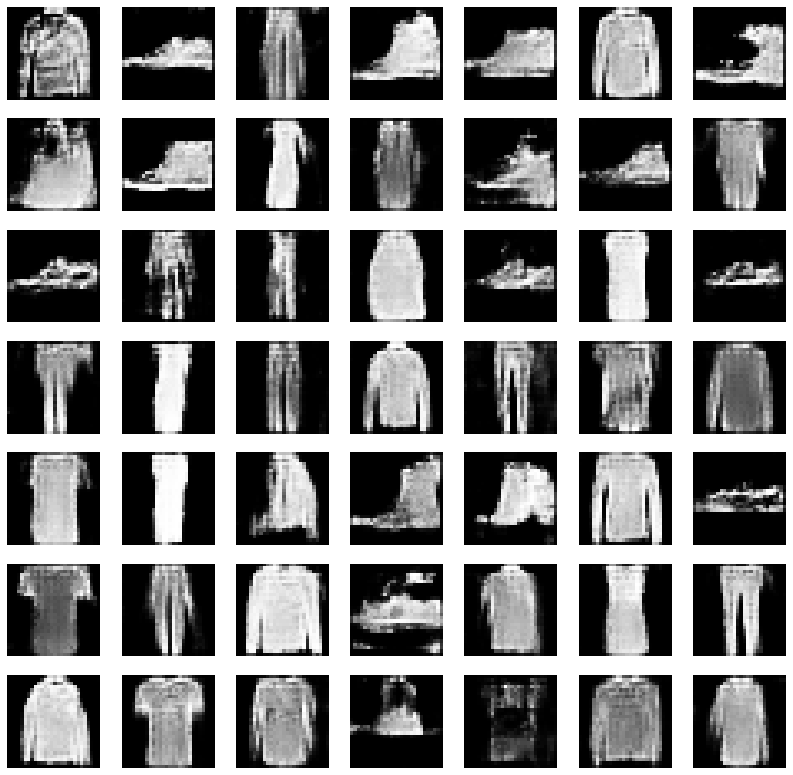

Epoch 5/20:
469/469 [==============================] - 17s 37ms/step
Epoch 6/20:
469/469 [==============================] - 17s 37ms/step


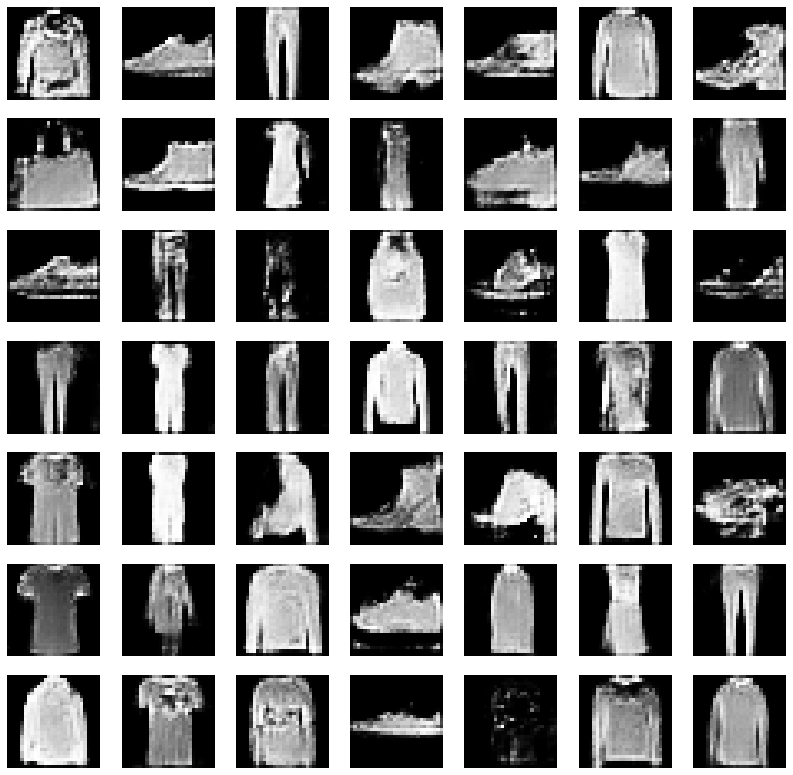

Epoch 7/20:
469/469 [==============================] - 17s 37ms/step
Epoch 8/20:
469/469 [==============================] - 17s 37ms/step


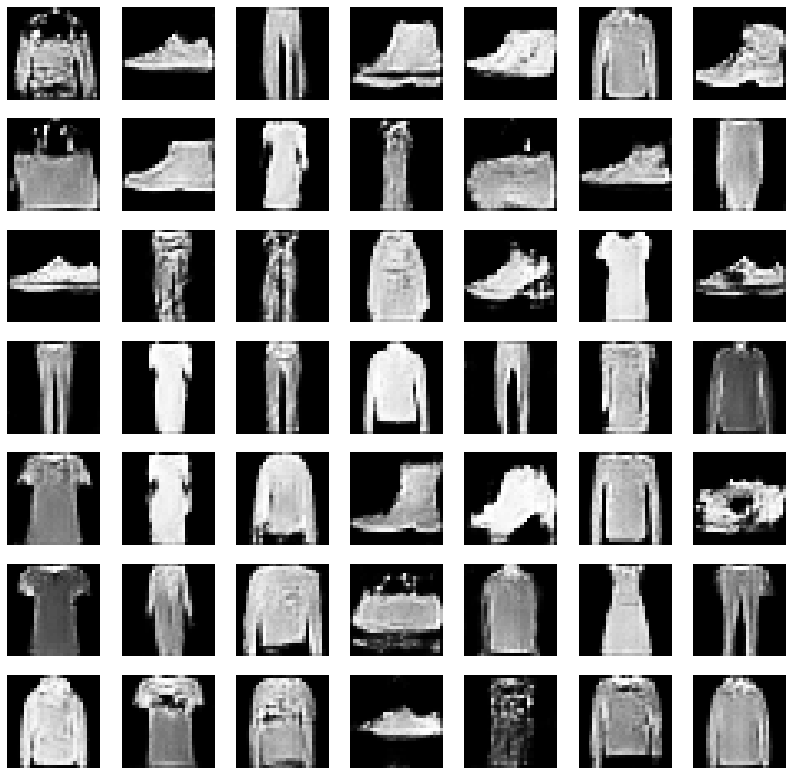

Epoch 9/20:
469/469 [==============================] - 17s 37ms/step
Epoch 10/20:
469/469 [==============================] - 17s 37ms/step


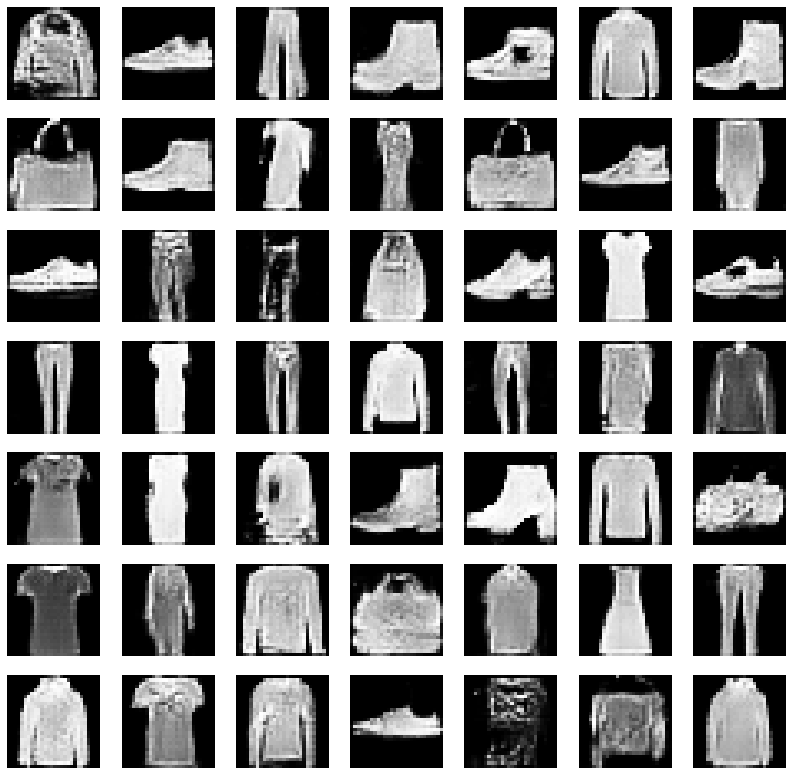

Epoch 11/20:
469/469 [==============================] - 17s 37ms/step
Epoch 12/20:
469/469 [==============================] - 17s 37ms/step


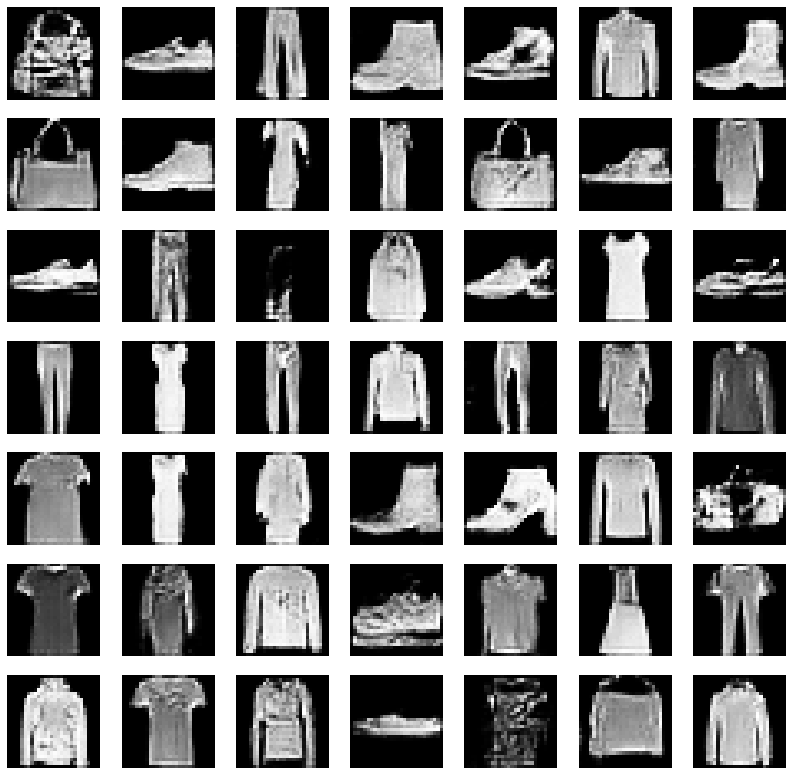

Epoch 13/20:
469/469 [==============================] - 17s 37ms/step
Epoch 14/20:
469/469 [==============================] - 17s 37ms/step


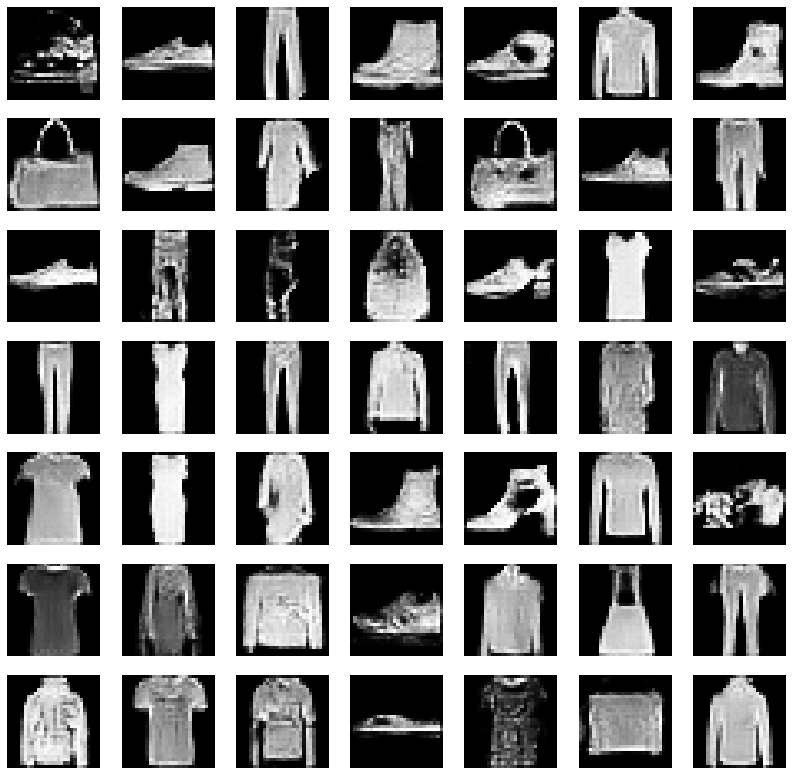

Epoch 15/20:
469/469 [==============================] - 17s 37ms/step
Epoch 16/20:
469/469 [==============================] - 17s 37ms/step


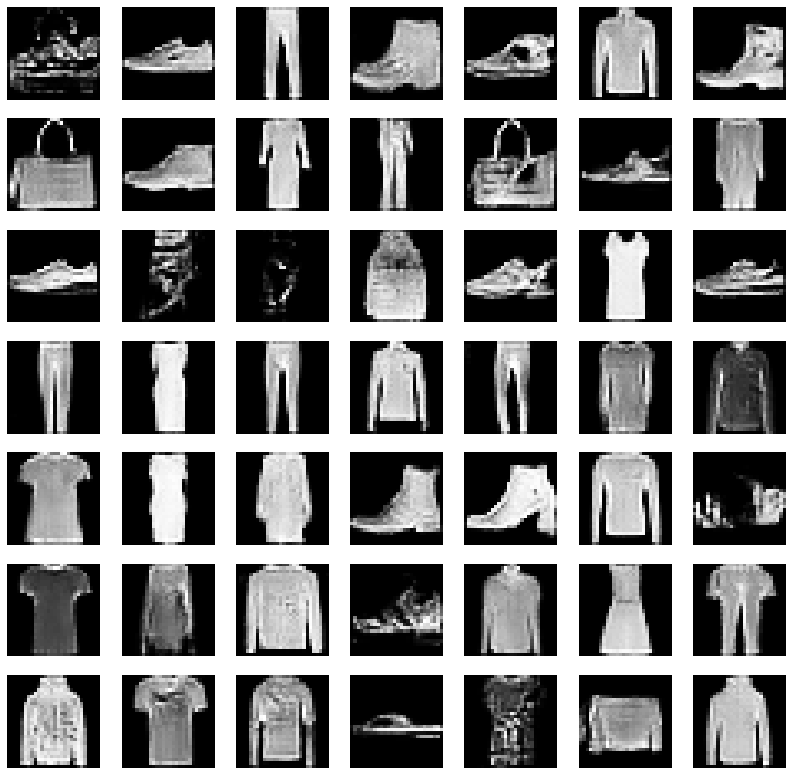

Epoch 17/20:
469/469 [==============================] - 17s 37ms/step
Epoch 18/20:
469/469 [==============================] - 17s 37ms/step


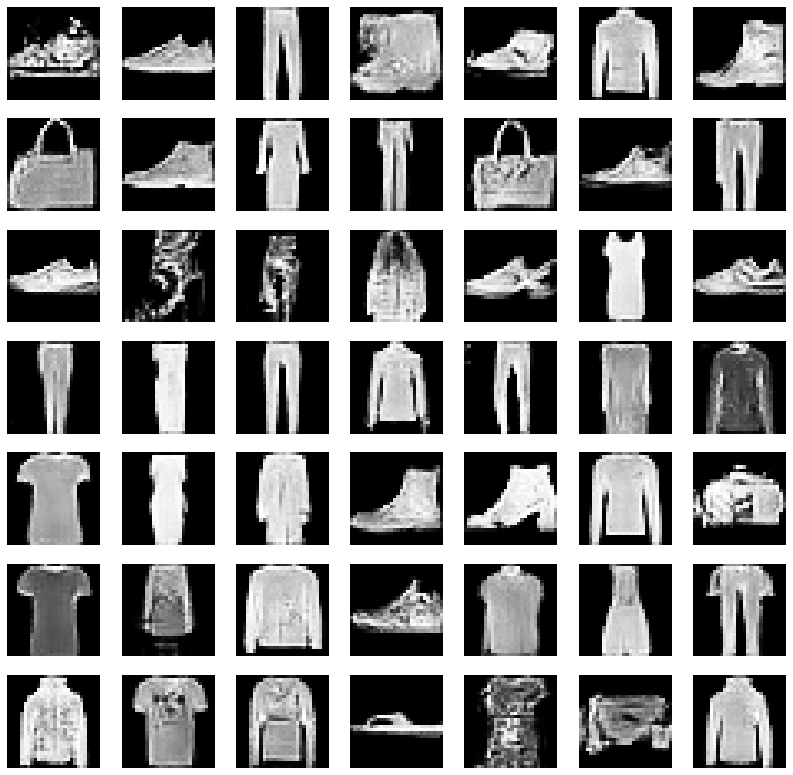

Epoch 19/20:
469/469 [==============================] - 17s 37ms/step
Epoch 20/20:
469/469 [==============================] - 17s 37ms/step


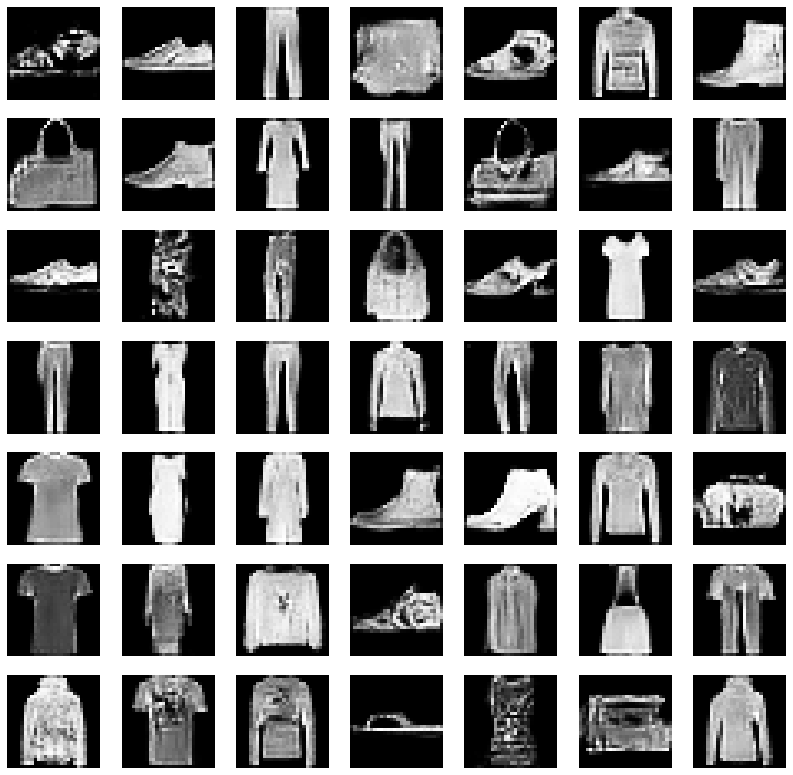

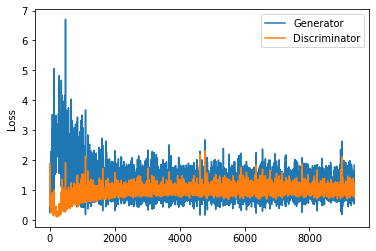

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 20

(ds_train, ds_test), ds_info = tfds.load('fashion_mnist', 
                                split=['train', 'test'],
                                as_supervised=True, 
                                with_info=True,
                                shuffle_files=True,
                                )
print("Real examples:")
tfds.show_examples(ds_train, ds_info)
ds_unsup = ds_train.map(lambda i, _: (tf.cast(i, tf.float32) - 127.5) / 127.5,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_unsup = ds_unsup.cache()
ds_unsup = ds_unsup.shuffle(BUFFER_SIZE)
ds_unsup = ds_unsup.batch(BATCH_SIZE)
ds_unsup = ds_unsup.prefetch(tf.data.experimental.AUTOTUNE)

losses = train(ds_unsup, EPOCHS).T

plt.plot(losses[0], label='Generator')
plt.plot(losses[1], label='Discriminator')
plt.ylabel("Loss")
plt.legend()
plt.show()

## Making a classifier
Using the discriminator's convolutions to create a classifier. 

Maxpooling first two convolutional blocks.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        800       
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  51200     
_________________________________________________________________
batch_normalization_4 (Batch multiple                  256   

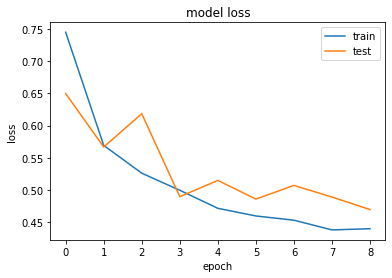

In [9]:
PER_CLASS = 1000
BATCH=16

cls_train = ds_train.map(lambda i, l: ((tf.cast(i, tf.float32) - 127.5) / 127.5, l), num_parallel_calls=tf.data.experimental.AUTOTUNE)
cls_train = ft.reduce(lambda a, v: a.concatenate(v), [cls_train.filter(lambda _,l: l == i).take(PER_CLASS) for i in range(10)])
cls_train = cls_train.cache().shuffle(10 * PER_CLASS).batch(BATCH).prefetch(tf.data.experimental.AUTOTUNE)
cls_test = ds_test.map(lambda i, l: ((tf.cast(i, tf.float32) - 127.5) / 127.5, l), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH).cache().prefetch(tf.data.experimental.AUTOTUNE)


x = D.layers[0]
h = x.output

for l in D.layers[1:-2]:
  l.trainable=False
  h = l(h)
  if isinstance(l, LeakyReLU):
    h = MaxPool2D(pool_size=(2, 2), padding="same")(h)

h = Flatten()(h)
h = BatchNormalization()(h)
h = Dense(32, activation="relu")(h)
h = Dense(10, activation="softmax")(h)

model = Model(inputs=x.input, outputs=h)
model.compile(
  optimizer=tf.keras.optimizers.Adam(0.005),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
model.summary()


history = model.fit(cls_train, epochs=9, validation_data=cls_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Exploring Latent Space
Linear interpolation of `COLS * ROWS` steps between `EXAMPLES` random examples in the latent space

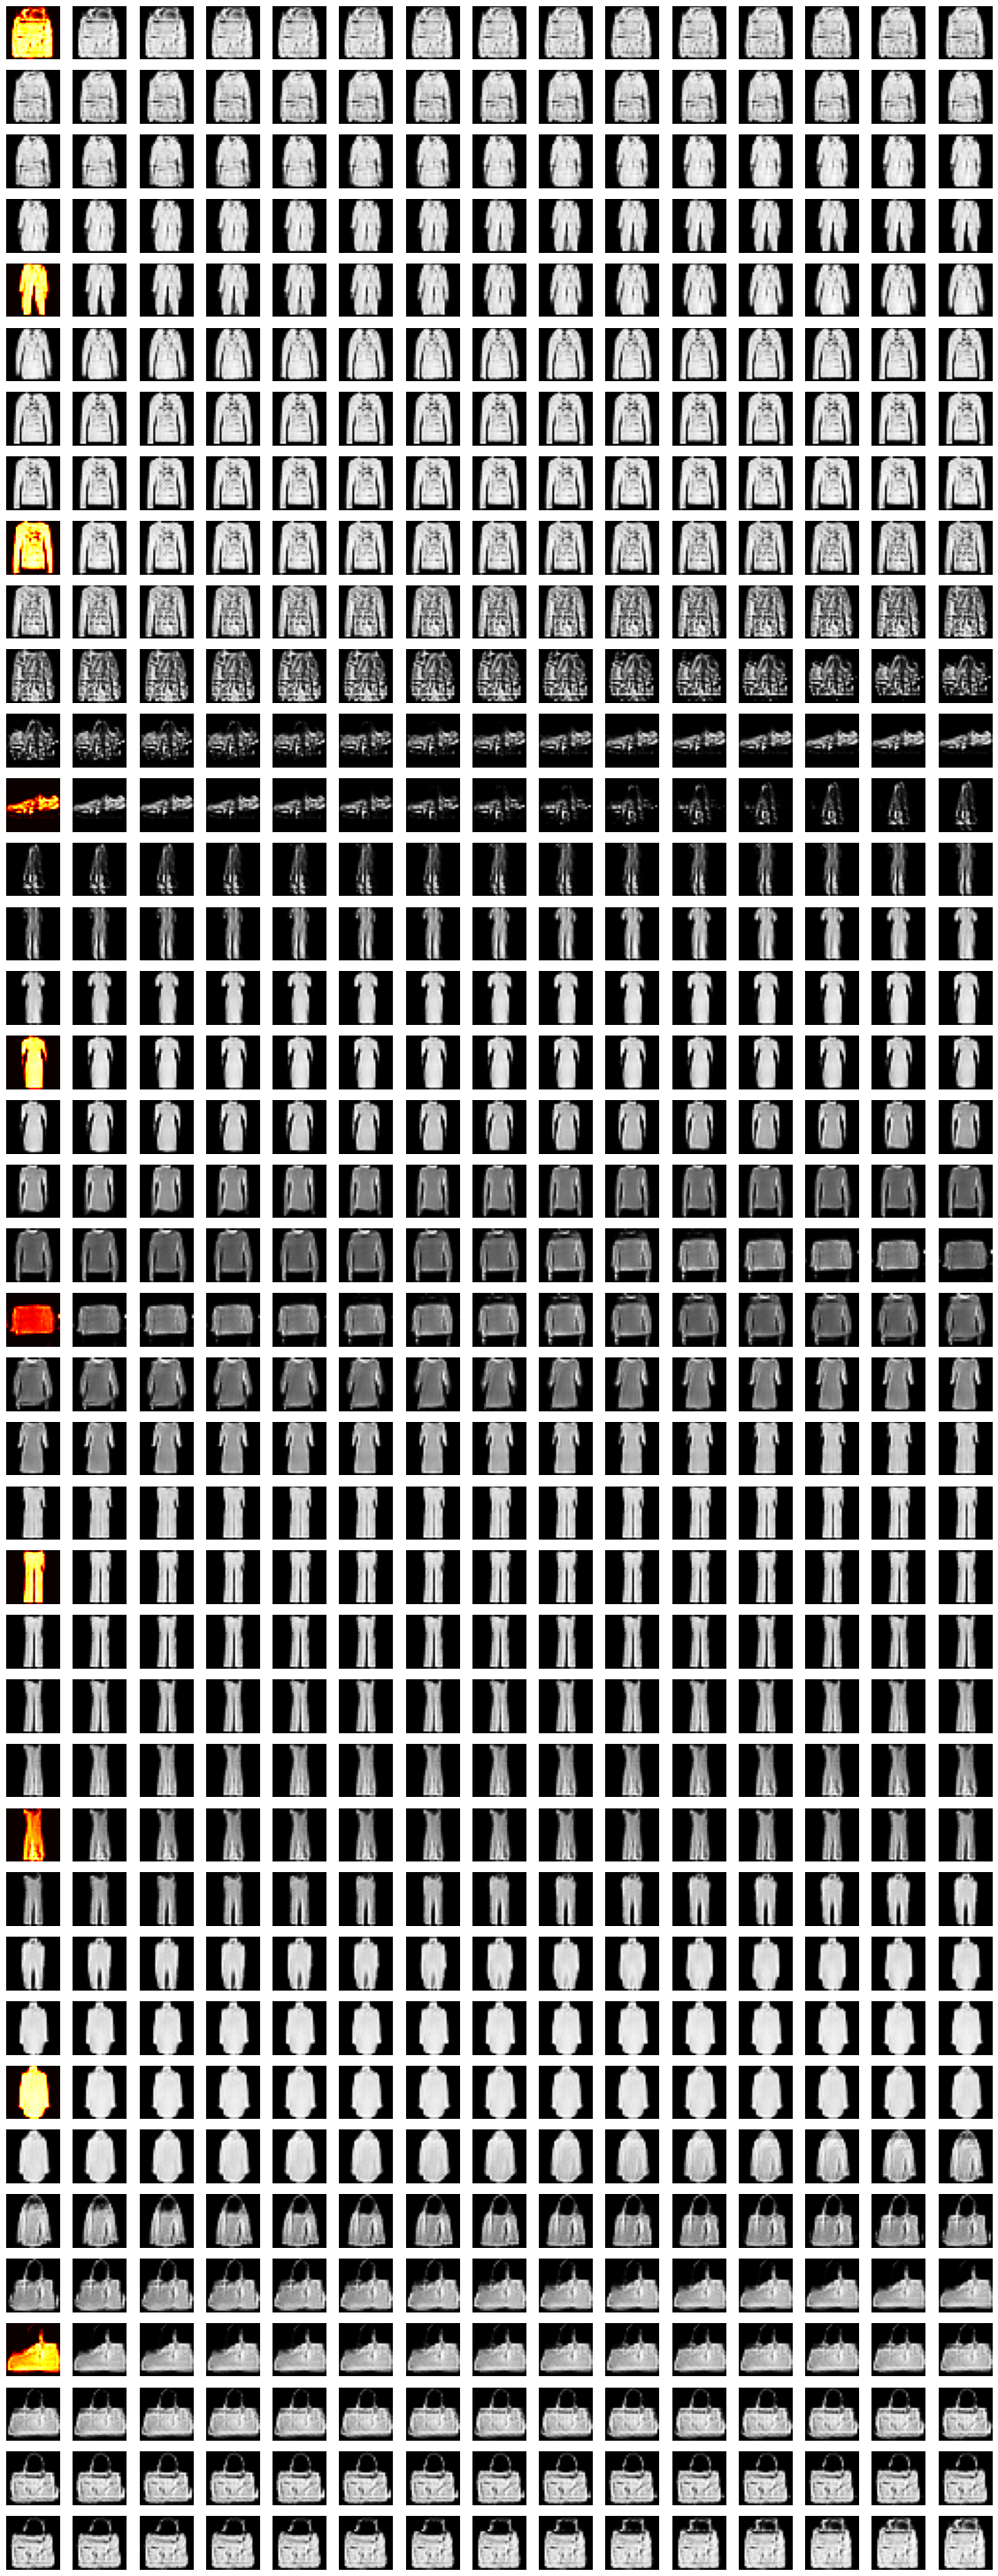

In [10]:
EXAMPLES = 10
COLS = 15
ROWS = 4

zs = tf.random.normal([EXAMPLES, NOISE_DIM])
zs = sorted(zs, key=np.average)
zs = zip(zs, zs[1:] + [zs[0]])
zs = np.concatenate(list(map(lambda z: tf.linspace(z[0], z[1], COLS * ROWS, axis=0), zs)))

images = G(zs, training=False)
plt.figure(figsize=(20, 20 * ROWS * EXAMPLES/COLS))

for i in range(len(images)):
  img = images[i]
  plt.subplot(EXAMPLES * ROWS, COLS, i + 1)
  plt.axis("off")
  plt.imshow(img.numpy().squeeze(), cmap=("hot" if i % (COLS * ROWS) == 0 else "gray"))

## Credits
Some parts of the code are highly inspired by the following sources:
- GAN: https://arxiv.org/abs/1406.2661
- DCGAN: https://arxiv.org/abs/1511.06434 
- Google ML: https://developers.google.com/machine-learning/gan/
- Pytorch: https://pytorch.org/
- TensorFlow: https://www.tensorflow.org/